In [1]:
import dask
import dask.threaded
import dask.multiprocessing
from dask.distributed import Client
c = Client()



/home/alberta/anaconda2/envs/pangeo-cloud/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/alberta/anaconda2/envs/pangeo-cloud/lib/python3.6/site-packages/distributed/bokeh/core.py:74: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [2]:
c


Client Scheduler: tcp://127.0.0.1:44563 Dashboard: http://127.0.0.1:37629/status,Cluster Workers: 4 Cores: 8 Memory: 33.66 GB


In [3]:
import xarray as xr
import numpy as np
import glob
import time
                                   

data_dir = '/home/alberta/occigen/eNATL60-BLBT02/'

tfiles = sorted(glob.glob(data_dir + '*/eNATL60-BLBT02_1h_*_gridT_20090701-20090701.nc'))
sfiles = sorted(glob.glob(data_dir + '*/eNATL60-BLBT02_1h_*_gridS_20090701-20090701.nc'))


In [4]:
def non_time_coords(ds):
    return [v for v in ds.data_vars
            if 'time_counter' not in ds[v].dims]

def drop_non_essential_vars_pop(ds):
    return ds.drop(non_time_coords(ds))

%time dst=xr.open_mfdataset(tfiles,parallel=True,concat_dim='time_counter',decode_cf=False,preprocess=drop_non_essential_vars_pop,chunks={'x':120,'y':120,'deptht':1,'time_counter':24}) 
%time dss=xr.open_mfdataset(sfiles,parallel=True,concat_dim='time_counter',decode_cf=False,preprocess=drop_non_essential_vars_pop,chunks={'x':120,'y':120,'deptht':1,'time_counter':24})


CPU times: user 3.92 s, sys: 436 ms, total: 4.36 s
Wall time: 12.4 s
CPU times: user 3.84 s, sys: 388 ms, total: 4.22 s
Wall time: 12.2 s


In [5]:
def compute_buoy(t,s):
    rau0  = 1000
    grav  = 9.81
    buoy= -1*(grav/rau0)*sigma0(t,s)
    return buoy

def sigma0(t,s):
    zrau0=1000
    zsr=np.sqrt(np.abs(s))
    zs=s
    zt=t
    zr1 = ( ( ( ( 6.536332e-9*zt-1.120083e-6 )*zt+1.001685e-4)*zt - 9.095290e-3 )*zt+6.793952e-2 )*zt+999.842594
    zr2= ( ( ( 5.3875e-9*zt-8.2467e-7 )*zt+7.6438e-5 ) *zt - 4.0899e-3 ) *zt+0.824493
    zr3= ( -1.6546e-6*zt+1.0227e-4 ) *zt-5.72466e-3
    zr4= 4.8314e-4
    sigma0=( zr4*zs + zr3*zsr + zr2 ) *zs + zr1 - zrau0
    return sigma0

In [6]:
def compute_buoy_all():
    temp=dst.votemper
    salt=dss.vosaline
    buoy=compute_buoy(temp,salt)
    return buoy

%time buoy=compute_buoy_all()


CPU times: user 36 ms, sys: 0 ns, total: 36 ms
Wall time: 33.1 ms


In [7]:
buoy

<xarray.DataArray (time_counter: 24, deptht: 300, y: 4729, x: 8354)>
dask.array<shape=(24, 300, 4729, 8354), dtype=float32, chunksize=(24, 1, 120, 120)>
Coordinates:
  * deptht        (deptht) float32 0.48045477 1.5587916 ... 5974.8853 6025.346
  * time_counter  (time_counter) float64 3.455e+09 3.455e+09 ... 3.455e+09
Dimensions without coordinates: y, x

In [9]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

%matplotlib inline

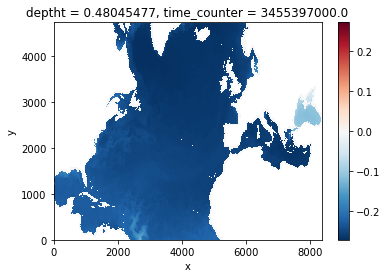

In [10]:
buoy[0,0].plot()